## Imports

In [1]:
# --- Standard Library ---
import os
import sys
import json
import random
import shutil
from collections import defaultdict
from typing import List, Dict, Tuple

# --- Numerical & Data Science ---
import numpy as np

# --- Machine Learning & Metrics ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models.video import r2plus1d_18
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, KFold

# --- Audio Processing ---
import librosa
import soundfile as sf

# --- Video Processing ---
import cv2
from moviepy.video.io.VideoFileClip import VideoFileClip

# --- TensorFlow (for YAMNet) ---
# import tensorflow as tf
# import tensorflow_hub as hub

# --- Torchaudio (for VGGish) ---
import torchaudio

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

# --- Other (if needed) ---
import torchvggish  # Uncomment if using torchvggish

In [11]:
# Load ResNet-50 model + TEMPORAL SEQUENCE AGGREGATOR (LSTM/TCN)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet-50 backbone (feature extractor)
try:
    from torchvision.models import ResNet50_Weights
    model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
except Exception:
    model = torchvision.models.resnet50(pretrained=True)

model.fc = torch.nn.Identity()  # 2048-d per-frame features
model.eval()
model.to(device)

# Preprocessing: resize -> tensor -> normalize
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
])

class TemporalAggregator(torch.nn.Module):
    """
    Temporal model over ordered per-frame embeddings.
    Modes:
      - 'mean': temporal average (no params)
      - 'lstm': BiLSTM over time + projection to 2048
      - 'tcn' : 1D temporal conv over time + projection to 2048
    Output: 2048-d clip embedding
    """
    def __init__(self, mode: str = 'mean', input_dim: int = 2048,
                 lstm_hidden: int = 512, tcn_hidden: int = 256):
        super().__init__()
        self.mode = mode.lower()
        self.input_dim = input_dim

        if self.mode == 'mean':
            self.net = None

        elif self.mode == 'lstm':
            self.lstm = torch.nn.LSTM(
                input_size=input_dim,
                hidden_size=lstm_hidden,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
            self.proj = torch.nn.Sequential(
                torch.nn.Linear(lstm_hidden * 2, input_dim),
                torch.nn.LayerNorm(input_dim)
            )

        elif self.mode == 'tcn':
            self.frame_proj = torch.nn.Linear(input_dim, tcn_hidden)
            self.tcn = torch.nn.Sequential(
                torch.nn.Conv1d(tcn_hidden, tcn_hidden, kernel_size=3, padding=1),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv1d(tcn_hidden, tcn_hidden, kernel_size=3, padding=2, dilation=2),
                torch.nn.ReLU(inplace=True),
            )
            self.proj = torch.nn.Sequential(
                torch.nn.Linear(tcn_hidden, input_dim),
                torch.nn.LayerNorm(input_dim)
            )
        else:
            raise ValueError(f"Unknown temporal mode: {mode}")

    def forward(self, seq_feats: torch.Tensor) -> torch.Tensor:
        """
        seq_feats: (T, D) or (B, T, D). Returns (D,) or (B, D).
        """
        if seq_feats.dim() == 2:
            seq_feats = seq_feats.unsqueeze(0)
            squeeze_back = True
        else:
            squeeze_back = False

        if self.mode == 'mean':
            out = seq_feats.mean(dim=1)  # (B, D)
        elif self.mode == 'lstm':
            _, (h_n, _) = self.lstm(seq_feats)  # h_n: (2, B, H)
            h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)  # (B, 2H)
            out = self.proj(h_last)  # (B, D)
        else:  # 'tcn'
            B, T, D = seq_feats.shape
            x = self.frame_proj(seq_feats)      # (B, T, C)
            x = x.transpose(1, 2)              # (B, C, T)
            x = self.tcn(x)                    # (B, C, T)
            x = x.mean(dim=2)                  # (B, C)
            out = self.proj(x)                 # (B, D)

        return out.squeeze(0) if squeeze_back else out

# Choose temporal mode: 'mean' (default), 'lstm', or 'tcn'
SEQ_MODEL_TYPE = 'lstm'  # change to 'tcn' or 'mean' as desired
temporal_aggregator = TemporalAggregator(mode=SEQ_MODEL_TYPE).to(device)
temporal_aggregator.eval()

# Optional: load trained temporal model weights (recommended for 'lstm'/'tcn')
SEQ_WEIGHTS_PATH = None  # e.g., "F:/AIM Lab/Experiment/sliding-window/temporal_agg_lstm.pth"
if SEQ_WEIGHTS_PATH and os.path.exists(SEQ_WEIGHTS_PATH):
    temporal_aggregator.load_state_dict(torch.load(SEQ_WEIGHTS_PATH, map_location=device))
    temporal_aggregator.eval()


def embed_clip(frames: List[np.ndarray], batch_size: int = 16):
    """
    Generate 2048-d clip embedding:
      1) Extract ordered per-frame 2048-d features (ResNet-50).
      2) Apply temporal aggregator (mean/LSTM/TCN) over time.
    """
    per_frame_feats = []
    batch = []

    # Keep original order; batch for speed
    for frame in frames:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(frame_rgb)  # <-- Convert to PIL Image
        batch.append(preprocess(pil_img))     # <-- Use PIL Image
        if len(batch) == batch_size:
            x = torch.stack(batch, 0).to(device)  # (B, 3, 224, 224)
            with torch.no_grad():
                f = model(x)  # (B, 2048)
            per_frame_feats.append(f.cpu())
            batch = []

    if batch:
        x = torch.stack(batch, 0).to(device)
        with torch.no_grad():
            f = model(x)
        per_frame_feats.append(f.cpu())

    if not per_frame_feats:
        return np.zeros(2048, dtype=np.float32)

    seq_feats = torch.cat(per_frame_feats, dim=0)  # (T, 2048)
    with torch.no_grad():
        clip_vec = temporal_aggregator(seq_feats.to(device)).cpu().numpy().astype(np.float32)
    return clip_vec


def sample_frames_from_video(video_path, num_samples=16):
    """
    Uniformly sample num_samples frames from the video at video_path.
    Returns a list of BGR frames (as numpy arrays).
    """
    print(f"Opening video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    if total_frames == 0:
        print(f"Error: No frames found in video {video_path}")
        return []
    
    dynamic_num_samples = num_samples
    if total_frames > 250:
        # Add 6 samples for every 100 frames after 200
        additional_samples = ((total_frames - 200) // 100) * 6
        dynamic_num_samples = num_samples + additional_samples
        
        print(f"Video has {total_frames} frames (>250), using {dynamic_num_samples} samples "
              f"(base {num_samples} + {additional_samples} additional)")
    else:
        print(f"Video has {total_frames} frames (≤250), using {dynamic_num_samples} samples")
    
    # Sample frames
    if total_frames < dynamic_num_samples:
        # If fewer frames than samples, just read them all
        indices = list(range(total_frames))
        print(f"Warning: Only {total_frames} frames available, using all of them")
    else:
        # Uniformly spaced frame indices
        indices = np.linspace(0, total_frames - 1, num=dynamic_num_samples, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Failed to read frame {idx} from {video_path}")
            continue
        frames.append(frame)
    cap.release()

    if not frames:
        print(f"Error: No frames sampled from video {video_path}")
    else:
        print(f"Successfully sampled {len(frames)} frames from {video_path}")
    
    return frames

def process_all_events(input_base_path, output_base_path, event_classes, num_samples=16):
    """
    Process all video clips in train/test folders for each event class.
    Generate ResNet-50 embeddings and save them maintaining the same directory structure.
    
    Args:
        input_base_path (str): Base path containing event folders
        output_base_path (str): Base path to save embeddings
        event_classes (list): List of event class names
        num_samples (int): Number of frames to sample per video
    """
    print(f"Processing videos from: {input_base_path}")
    print(f"Saving embeddings to: {output_base_path}")
    
    total_processed = 0
    
    for event in event_classes:
        event_input_folder = os.path.join(input_base_path, event)
        event_output_folder = os.path.join(output_base_path, event)
        
        if not os.path.exists(event_input_folder):
            print(f"Warning: Event folder not found: {event_input_folder}")
            continue
            
        print(f"\nProcessing event: {event}")
        
        # Process both train and test folders
        for split in ['train', 'test']:
            split_input_folder = os.path.join(event_input_folder, split)
            split_output_folder = os.path.join(event_output_folder, split)
            
            if not os.path.exists(split_input_folder):
                print(f"  Warning: Split folder not found: {split_input_folder}")
                continue
            
            # Create output directory
            os.makedirs(split_output_folder, exist_ok=True)
            
            print(f"  Processing {event}/{split}...")
            
            # Get all video files
            video_files = [f for f in os.listdir(split_input_folder) if f.lower().endswith('.mp4')]
            print(f"    Found {len(video_files)} videos")
            
            for fname in video_files:
                video_path = os.path.join(split_input_folder, fname)
                print(f"    Processing video: {fname}")
                
                # Sample frames from video
                frames = sample_frames_from_video(video_path, num_samples=num_samples)
                
                if frames:
                    # Generate mean-pooled embedding (single embedding per clip)
                    embedding = embed_clip(frames)
                    
                    # Save the embedding as a .npy file with same name
                    output_path = os.path.join(split_output_folder, f"{os.path.splitext(fname)[0]}.npy")
                    np.save(output_path, embedding)
                    print(f"    Saved embedding to {output_path} (shape: {embedding.shape})")
                    total_processed += 1
                else:
                    print(f"    Error: No frames sampled from {fname}")
    
    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE!")
    print(f"Total videos processed: {total_processed}")
    print(f"Embeddings saved to: {output_base_path}")
    print(f"{'='*60}")

# Example usage
if __name__ == "__main__":
    # Define paths
    input_base_path = "F:/AIM Lab/Experiment/sliding-window/Clips"
    output_base_path = "E:/AIM/Resnet-50 embeddings"
    
    # Define event classes
    event_classes = [
        "Goal", "Red_card", "Direct_free-kick", "Penalty", "Substitution", "Shots_on_target", "no_event"
    ]
    
    # Process all events with train/test structure
    process_all_events(
        input_base_path=input_base_path,
        output_base_path=output_base_path,
        event_classes=event_classes,
        num_samples=16
    )

Processing videos from: F:/AIM Lab/Experiment/sliding-window/Clips
Saving embeddings to: E:/AIM/Resnet-50 embeddings

Processing event: Goal
  Processing Goal/train...
    Found 72 videos
    Processing video: 10_england_epl_2015-2016_2015_08_29___17_00_Manchester_City_2___0_Watford.mp4
Opening video: F:/AIM Lab/Experiment/sliding-window/Clips\Goal\train\10_england_epl_2015-2016_2015_08_29___17_00_Manchester_City_2___0_Watford.mp4
Total frames in video: 200
Video has 200 frames (≤250), using 16 samples
Successfully sampled 16 frames from F:/AIM Lab/Experiment/sliding-window/Clips\Goal\train\10_england_epl_2015-2016_2015_08_29___17_00_Manchester_City_2___0_Watford.mp4
    Saved embedding to E:/AIM/Resnet-50 embeddings\Goal\train\10_england_epl_2015-2016_2015_08_29___17_00_Manchester_City_2___0_Watford.npy (shape: (2048,))
    Processing video: 11_england_epl_2015-2016_2015_09_12___14_45_Everton_3___1_Chelsea.mp4
Opening video: F:/AIM Lab/Experiment/sliding-window/Clips\Goal\train\11_eng

KeyboardInterrupt: 

## Test/Train Split

In [ ]:
def split_videos(base_path, event_types, train_ratio=0.8, test_ratio=0.2):
    """
    Split videos into train and test subfolders for each event type based on unequal sample sizes.
    For "Red card" and "Penalty", ensure all three samples of an event (normal, before, after) remain together.
    
    Args:
        base_path (str): Path to the base folder containing event folders.
        event_types (list): List of event types to process.
        train_ratio (float): Proportion of videos to place in the train folder.
        test_ratio (float): Proportion of videos to place in the test folder.
    """
    for event in event_types:
        event_folder = os.path.join(base_path, event.replace(" ", "_"))
        train_folder = os.path.join(event_folder, "train")
        test_folder = os.path.join(event_folder, "test")
        
        # Create train and test subfolders if they don't exist
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)
        
        # Get all video files in the event folder
        video_files = [f for f in os.listdir(event_folder) if f.endswith(".mp4")]
        
        if event in ["Red card", "Penalty"]:
            # Group files by event (normal, before, after)
            grouped_files = defaultdict(list)
            for filename in video_files:
                # Extract the base event identifier (e.g., "1_match_normal", "1_match_before", "1_match_after")
                base_event = "_".join(filename.split("_")[:2])  # First two parts of the filename
                grouped_files[base_event].append(filename)
            
            # Shuffle the grouped events to ensure randomness
            grouped_events = list(grouped_files.items())
            random.shuffle(grouped_events)
            
            # Calculate the number of train and test events
            total_events = len(grouped_events)
            num_train_events = int(total_events * train_ratio)
            num_test_events = total_events - num_train_events
            
            # Split events into train and test sets
            train_events = grouped_events[:num_train_events]
            test_events = grouped_events[num_train_events:]
            
            # Move grouped files to train folder
            for base_event, files in train_events:
                for file in files:
                    src_path = os.path.join(event_folder, file)
                    dest_path = os.path.join(train_folder, file)
                    shutil.move(src_path, dest_path)
            
            # Move grouped files to test folder
            for base_event, files in test_events:
                for file in files:
                    src_path = os.path.join(event_folder, file)
                    dest_path = os.path.join(test_folder, file)
                    shutil.move(src_path, dest_path)
            
            print(f"Event: {event}")
            print(f"  Total events: {total_events}")
            print(f"  Train events: {len(train_events)}")
            print(f"  Test events: {len(test_events)}")
        else:
            # Shuffle the video files to ensure randomness
            random.shuffle(video_files)
            
            # Calculate the number of train and test videos
            total_videos = len(video_files)
            num_train_videos = int(total_videos * train_ratio)
            num_test_videos = total_videos - num_train_videos
            
            # Split videos into train and test sets
            train_videos = video_files[:num_train_videos]
            test_videos = video_files[num_train_videos:]
            
            # Move videos to train folder
            for video in train_videos:
                src_path = os.path.join(event_folder, video)
                dest_path = os.path.join(train_folder, video)
                shutil.move(src_path, dest_path)
            
            # Move videos to test folder
            for video in test_videos:
                src_path = os.path.join(event_folder, video)
                dest_path = os.path.join(test_folder, video)
                shutil.move(src_path, dest_path)
            
            print(f"Event: {event}")
            print(f"  Total videos: {total_videos}")
            print(f"  Train videos: {len(train_videos)}")
            print(f"  Test videos: {len(test_videos)}")

if __name__ == "__main__":
    # Define base paths for Clips and Features-processed
    base_paths = [
        "F:/AIM Lab/Experiment/sliding-window/Clips"
    ]
    
    # List of event types to process
    event_types = ["Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty", "Indirect_free-kick", "Corner", "Substitution", "Shots_on_target", "no_event"]
    
    # Split videos in both base paths
    for base_path in base_paths:
        split_videos(base_path, event_types)

## Handy Crafted Features from video

In [ ]:
"""
Extract compact handcrafted video features per clip:
 - Optical Flow statistics (6-8 dims)
 - Shot-transition / cut-rate features (3-4 dims)

Saves embeddings into: video_features/<Class>/<train|test>/<clip_stem>.npy
"""

import os
import cv2
import numpy as np
from tqdm import tqdm
import argparse
import math

VIDEO_EXTS = {".mp4", ".avi", ".mov", ".mkv", ".mpeg", ".mpg", ".wmv"}


def is_video_file(path):
    return os.path.splitext(path)[1].lower() in VIDEO_EXTS


def read_video_frames(video_path, max_frames=None, resize_shorter=640):
    """
    Read all frames from video (grayscale), optionally resizing for speed.
    Returns list of frames (uint8) in grayscale.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    frames = []
    success, frame = cap.read()
    while success:
        # convert to grayscale for optical flow & difference
        if resize_shorter is not None:
            h, w = frame.shape[:2]
            scale = resize_shorter / float(min(h, w))
            if scale < 1.0:
                frame = cv2.resize(frame, (int(w * scale), int(h * scale)),
                                   interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
        success, frame = cap.read()
        if max_frames is not None and len(frames) >= max_frames:
            break
    cap.release()
    return frames, fps



def optical_flow_stats(frames, flow_method="farneback", smooth_window=3):
    """
    Compute per-frame optical-flow magnitude statistics and summarize.
    """
    T = len(frames)
    if T < 2:
        return np.zeros(8, dtype=np.float32)

    mags = []
    prev = frames[0]

    # Try fast DIS optical flow if available (opencv-contrib), else lighter Farneback
    use_dis = (flow_method == "dis")
    if use_dis and hasattr(cv2, "DISOpticalFlow_create"):
        dis = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_FAST)

    for i in range(1, T):
        curr = frames[i]
        if use_dis and hasattr(cv2, "DISOpticalFlow_create"):
            flow = dis.calc(prev, curr, None)
            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        else:
            # Relaxed Farneback params for speed
            flow = cv2.calcOpticalFlowFarneback(
                prev, curr, None,
                pyr_scale=0.5, levels=2, winsize=9,
                iterations=2, poly_n=5, poly_sigma=1.1, flags=0
            )
            mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        m = float(np.mean(mag))
        mags.append(m)
        prev = curr

    mags = np.array(mags)
    if smooth_window > 1 and len(mags) >= smooth_window:
        kernel = np.ones(smooth_window) / smooth_window
        mags = np.convolve(mags, kernel, mode="same")

    mean_m = mags.mean()
    std_m = mags.std()
    max_m = mags.max()
    median_m = np.median(mags)
    q25 = np.percentile(mags, 25)
    q75 = np.percentile(mags, 75)
    idx_max = int(np.argmax(mags))
    time_of_max = idx_max / max(1, (len(mags) - 1))
    k = 1.0
    threshold = mean_m + k * std_m
    peaks = int(np.sum((mags[1:-1] > mags[:-2]) & (mags[1:-1] > mags[2:]) & (mags[1:-1] > threshold)))

    vec= np.array([mean_m, std_m, max_m, median_m, q25, q75, time_of_max, peaks], dtype=np.float32)
    return vec


def shot_transition_features(frames, fps, downscale=0.25, cut_k=2.0):
    """
    Detect shot cuts via frame-to-frame difference on downscaled grayscale frames.
    Returns vector of shot features: num_cuts, cuts_per_sec, median_shot_len_sec, shot_len_std
    """
    T = len(frames)
    if T < 2:
        return np.zeros(4, dtype=np.float32)

    # downsample frames for diff speed
    small_frames = []
    for f in frames:
        h, w = f.shape[:2]
        nw, nh = max(1, int(w * downscale)), max(1, int(h * downscale))
        small_frames.append(cv2.resize(f, (nw, nh), interpolation=cv2.INTER_AREA).astype(np.float32) / 255.0)

    diffs = []
    for i in range(1, len(small_frames)):
        # L1/frame mean
        d = np.mean(np.abs(small_frames[i] - small_frames[i - 1]))
        diffs.append(d)
    diffs = np.array(diffs)

    # threshold adaptively: mean + cut_k * std
    mu, sigma = diffs.mean(), diffs.std()
    thr = mu + cut_k * sigma
    cut_flags = diffs > thr
    num_cuts = int(cut_flags.sum())

    # shot lengths in frames: segments between cuts
    # if no cuts: one shot of full length
    cut_indices = np.where(cut_flags)[0].tolist()
    # convert diffs idx -> cut occurs between frame i and i+1; shot boundaries:
    boundaries = [0] + [i + 1 for i in cut_indices] + [T]
    shot_lengths = []
    for i in range(len(boundaries) - 1):
        shot_len = boundaries[i + 1] - boundaries[i]
        shot_lengths.append(shot_len)
    shot_lengths = np.array(shot_lengths, dtype=np.float32)
    shot_len_secs = shot_lengths / max(1.0, fps)

    median_shot_len = float(np.median(shot_len_secs))
    shot_len_std = float(np.std(shot_len_secs))
    clip_duration_sec = max(1.0, T / max(1.0, fps))
    cuts_per_sec = num_cuts / clip_duration_sec

    vec = np.array([num_cuts, cuts_per_sec, median_shot_len, shot_len_std], dtype=np.float32)
    return vec


def process_clip(video_path):
    """
    Process a single video clip and return a compact handcrafted embedding.
    Embedding layout (approx 12 dims):
      [opt_flow:8] + [shot_feats:4] => total 12 dims (float32)
    """
    frames, fps = read_video_frames(video_path, resize_shorter=640)
    if len(frames) < 2:
        # create zero embedding
        embedding = np.zeros(12, dtype=np.float32)
        return embedding

    opt_vec = optical_flow_stats(frames, flow_method="dis" if hasattr(cv2, "DISOpticalFlow_create") else "farneback")  # 8 dims
    shot_vec = shot_transition_features(frames, fps)  # 4 dims

    embedding = np.concatenate([opt_vec, shot_vec], axis=0)
    return embedding

from concurrent.futures import ProcessPoolExecutor, as_completed
# add imports and a helper right after the above line
from concurrent.futures import ThreadPoolExecutor
import sys

def _in_notebook():
    # True when running under Jupyter/IPython kernel
    return 'ipykernel' in sys.modules

def _init_worker():
    # Avoid oversubscription inside each worker
    try:
        cv2.setNumThreads(1)
    except Exception:
        pass
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS", "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")


def save_embedding(dest_base, class_name, split, clip_path, emb):
    """
    Save embedding as numpy .npy with same relative structure under dest_base.
    """
    stem = os.path.splitext(os.path.basename(clip_path))[0]
    out_dir = os.path.join(dest_base, class_name, split)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, stem + ".npy")
    np.save(out_path, emb.astype(np.float32))
    return out_path

def _process_and_save(args):
    cls, split, path, out_root = args
    emb = process_clip(path)
    save_embedding(out_root, cls, split, path, emb)
    return path

def main(clips_root="F:\\AIM Lab\\Experiment\\sliding-window\\Clips", out_root="F:\\AIM Lab\\Experiment\\sliding-window\\video_features", classes=None, max_workers=None):
    """
    Walk clips_root/<class>/<train|test> and process videos.
    """
    if classes is None:
        # try to auto-detect classes from folders
        classes = [d for d in os.listdir(clips_root) if os.path.isdir(os.path.join(clips_root, d))]
        classes.sort()

    print(f"Detected classes: {classes}")
    tasks = []
    for cls in classes:
        for split in ["train", "test"]:
            folder = os.path.join(clips_root, cls, split)
            if not os.path.isdir(folder):
                continue
            for fname in os.listdir(folder):
                path = os.path.join(folder, fname)
                if is_video_file(path):
                    tasks.append((cls, split, path, out_root))

    if not tasks:
        print("No videos found.")
        return

    workers = max_workers or max(1, (os.cpu_count() or 2) - 1)
    use_threads = (_in_notebook() and os.name == 'nt')
    print(f"Processing {len(tasks)} files with {workers} {'threads' if use_threads else 'processes'}...")
    completed = 0
    Executor = ThreadPoolExecutor if use_threads else ProcessPoolExecutor
    init_kwargs = {} if use_threads else dict(initializer=_init_worker)

    with Executor(max_workers=workers, **init_kwargs) as ex:
        futures = [ex.submit(_process_and_save, t) for t in tasks]
        for fut in as_completed(futures):
            try:
                _ = fut.result()
            except Exception as e:
                print(f"Error: {e}")
            completed += 1
            if completed % 20 == 0:
                print(f"Done {completed}/{len(tasks)}")



if __name__ == "__main__":
    main()


## Generating ResNet-50 embeddings for RGB video clip

In [ ]:
# Load ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove the final classifier to get 2048-d features
model.eval()  # Set the model to evaluation mode

# Preprocessing pipeline for frames
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                    # H×W×C → C×H×W, [0,1]
    torchvision.transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
    torchvision.transforms.Resize((224, 224)),
])

def embed_clip(frames: List[np.ndarray]):
    """
    Generate ResNet-50 embeddings for a list of frames.
    
    Args:
        frames (List[np.ndarray]): List of frames (H×W×C, BGR format).
    
    Returns:
        np.ndarray: Mean-pooled embedding (2048,) - single embedding per clip.
    """
    feats = []
    for frame in frames:
        # Convert BGR (OpenCV) to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x = preprocess(frame_rgb).unsqueeze(0)  # 1×3×224×224
        with torch.no_grad():
            f = model(x)  # 1×2048
        feats.append(f.squeeze(0).cpu().numpy())
    
    # Return mean-pooled embedding (single embedding per clip)
    return np.mean(feats, axis=0)  # (2048,)

def sample_frames_from_video(video_path, num_samples=16):
    """
    Uniformly sample num_samples frames from the video at video_path.
    Returns a list of BGR frames (as numpy arrays).
    """
    print(f"Opening video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    if total_frames == 0:
        print(f"Error: No frames found in video {video_path}")
        return []
    
    dynamic_num_samples = num_samples
    if total_frames > 250:
        # Add 6 samples for every 100 frames after 200
        additional_samples = ((total_frames - 200) // 100) * 6
        dynamic_num_samples = num_samples + additional_samples
        
        print(f"Video has {total_frames} frames (>250), using {dynamic_num_samples} samples "
              f"(base {num_samples} + {additional_samples} additional)")
    else:
        print(f"Video has {total_frames} frames (≤250), using {dynamic_num_samples} samples")
    
    # Sample frames
    if total_frames < dynamic_num_samples:
        # If fewer frames than samples, just read them all
        indices = list(range(total_frames))
        print(f"Warning: Only {total_frames} frames available, using all of them")
    else:
        # Uniformly spaced frame indices
        indices = np.linspace(0, total_frames - 1, num=dynamic_num_samples, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Failed to read frame {idx} from {video_path}")
            continue
        frames.append(frame)
    cap.release()

    if not frames:
        print(f"Error: No frames sampled from video {video_path}")
    else:
        print(f"Successfully sampled {len(frames)} frames from {video_path}")
    
    return frames

def process_all_events(input_base_path, output_base_path, event_classes, num_samples=16):
    """
    Process all video clips in train/test folders for each event class.
    Generate ResNet-50 embeddings and save them maintaining the same directory structure.
    
    Args:
        input_base_path (str): Base path containing event folders
        output_base_path (str): Base path to save embeddings
        event_classes (list): List of event class names
        num_samples (int): Number of frames to sample per video
    """
    print(f"Processing videos from: {input_base_path}")
    print(f"Saving embeddings to: {output_base_path}")
    
    total_processed = 0
    
    for event in event_classes:
        event_input_folder = os.path.join(input_base_path, event)
        event_output_folder = os.path.join(output_base_path, event)
        
        if not os.path.exists(event_input_folder):
            print(f"Warning: Event folder not found: {event_input_folder}")
            continue
            
        print(f"\nProcessing event: {event}")
        
        # Process both train and test folders
        for split in ['train', 'test']:
            split_input_folder = os.path.join(event_input_folder, split)
            split_output_folder = os.path.join(event_output_folder, split)
            
            if not os.path.exists(split_input_folder):
                print(f"  Warning: Split folder not found: {split_input_folder}")
                continue
            
            # Create output directory
            os.makedirs(split_output_folder, exist_ok=True)
            
            print(f"  Processing {event}/{split}...")
            
            # Get all video files
            video_files = [f for f in os.listdir(split_input_folder) if f.lower().endswith('.mp4')]
            print(f"    Found {len(video_files)} videos")
            
            for fname in video_files:
                video_path = os.path.join(split_input_folder, fname)
                print(f"    Processing video: {fname}")
                
                # Sample frames from video
                frames = sample_frames_from_video(video_path, num_samples=num_samples)
                
                if frames:
                    # Generate mean-pooled embedding (single embedding per clip)
                    embedding = embed_clip(frames)
                    
                    # Save the embedding as a .npy file with same name
                    output_path = os.path.join(split_output_folder, f"{os.path.splitext(fname)[0]}.npy")
                    np.save(output_path, embedding)
                    print(f"    Saved embedding to {output_path} (shape: {embedding.shape})")
                    total_processed += 1
                else:
                    print(f"    Error: No frames sampled from {fname}")
    
    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE!")
    print(f"Total videos processed: {total_processed}")
    print(f"Embeddings saved to: {output_base_path}")
    print(f"{'='*60}")

# Example usage
if __name__ == "__main__":
    # Define paths
    input_base_path = "F:/AIM Lab/Experiment/sliding-window/Clips"
    output_base_path = "F:/AIM Lab/Experiment/sliding-window/Resnet-50 embeddings rgb"
    
    # Define event classes
    event_classes = [
        "Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty", 
        "Indirect_free-kick", "Corner", "Substitution", "Shots_on_target", "no_event"
    ]
    
    # Process all events with train/test structure
    process_all_events(
        input_base_path=input_base_path,
        output_base_path=output_base_path,
        event_classes=event_classes,
        num_samples=16
    )

## Audio Extraction 

In [ ]:
import os
from moviepy import VideoFileClip

def extract_audio_from_video(video_path, audio_path, duration=7.0):
    try:
        video = VideoFileClip(video_path)
        audio = video.audio
        if audio is not None:
            audio = audio.subclipped(0, min(duration, video.duration))
            audio.write_audiofile(audio_path, fps=16000, codec='pcm_s16le', logger=None)
            print(f"Extracted audio: {audio_path}")
        else:
            print(f"No audio found in {video_path}")
        video.close()
    except Exception as e:
        print(f"Error extracting audio: {e}")

def batch_extract_audio(clips_dir, audio_dir):
    os.makedirs(audio_dir, exist_ok=True)
    for fname in os.listdir(clips_dir):
        if fname.endswith('.mp4'):
            video_path = os.path.join(clips_dir, fname)
            audio_path = os.path.join(audio_dir, os.path.splitext(fname)[0] + '.wav')
            extract_audio_from_video(video_path, audio_path)

# Example usage for all events and splits
base_clip_dir = "F:/AIM Lab/Experiment/sliding-window/Clips"
base_audio_dir = "F:/AIM Lab/Experiment/sliding-window/Audio"
event_classes =["Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty", "Indirect_free-kick", "Corner", "Substitution", "Shots_on_target", "no_event"]
splits = ["train", "test"]

for event in event_classes:
    for split in splits:
        clips_dir = os.path.join(base_clip_dir, event, split)
        audio_dir = os.path.join(base_audio_dir, event, split)
        batch_extract_audio(clips_dir, audio_dir)

## Handy-Crafted features from audio

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Your event classes
event_classes = [
    "Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty",
    "Indirect_free-kick", "Corner", "Substitution", "Shots_on_target", "no_event"
]

# Directory containing the clips
base_dir = "F:\\AIM Lab\\Experiment\\sliding-window\\Audio"

# Base directory to save embeddings (same structure as clips/)
out_base = "F:\\AIM Lab\\Experiment\\sliding-window\\audio_features"

# MFCC config
N_MFCC = 13

def extract_audio_features(file_path, n_mfcc=N_MFCC):
    """
    Extract aggregated MFCC stats (mean, std, max, min), average pitch, and avg RMS energy.
    Returns:
      features: 1D numpy array of length (n_mfcc*4 + 2)
      feature_names: list of names in same order
    """
    # load audio
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs: shape (n_mfcc, time_frames)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # stats per MFCC coefficient across time
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std  = np.std(mfccs, axis=1)
    mfcc_max  = np.max(mfccs, axis=1)
    mfcc_min  = np.min(mfccs, axis=1)

    # Average pitch (harmonic)
    try:
        y_harmonic, _ = librosa.effects.hpss(y)
        pitches, magnitudes = librosa.piptrack(y=y_harmonic, sr=sr)
        # Select pitch candidates where magnitude is relatively strong
        mag_thresh = np.median(magnitudes[magnitudes > 0]) if np.any(magnitudes > 0) else 0.0
        pitch_values = pitches[magnitudes > mag_thresh]
        avg_pitch = float(np.mean(pitch_values)) if pitch_values.size > 0 else 0.0
    except Exception:
        avg_pitch = 0.0

    # RMS energy
    rms = librosa.feature.rms(y=y)
    avg_rms = float(np.mean(rms)) if rms.size > 0 else 0.0

    # concatenate in the order: mean, std, max, min, avg_pitch, avg_rms
    features = np.hstack([mfcc_mean, mfcc_std, mfcc_max, mfcc_min, avg_pitch, avg_rms])

    # build feature names for CSV header / debugging
    names = []
    for stat in ["mean", "std", "max", "min"]:
        for i in range(n_mfcc):
            names.append(f"mfcc{i+1}_{stat}")
    names += ["avg_pitch", "avg_rms"]

    return features.astype(np.float32), names

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

# Containers for CSV exports
rows_train = []
rows_test = []

# Process files
for split in ["train", "test"]:
    for cls in event_classes:
        in_folder = os.path.join(base_dir, cls, split)
        out_folder = os.path.join(out_base, cls, split)
        if not os.path.exists(in_folder):
            # skip missing class/split folders silently
            continue
        ensure_dir(out_folder)

        file_list = [f for f in os.listdir(in_folder) if f.lower().endswith(".wav")]
        if not file_list:
            continue

        for fname in tqdm(file_list, desc=f"{cls}/{split}", leave=False):
            in_path = os.path.join(in_folder, fname)
            try:
                feats, feat_names = extract_audio_features(in_path, n_mfcc=N_MFCC)
            except Exception as e:
                print(f"Error processing {in_path}: {e}")
                continue

            # Save per-clip embedding .npy (same name as audio but .npy)
            base_name = os.path.splitext(fname)[0]
            out_path = os.path.join(out_folder, base_name + ".npy")
            np.save(out_path, feats)

            # record metadata for CSV
            row = {"class": cls, "split": split, "audio_file": in_path, "embedding_file": out_path}
            # add features as columns (optional but handy)
            for name, val in zip(feat_names, feats):
                row[name] = float(val)
            if split == "train":
                rows_train.append(row)
            else:
                rows_test.append(row)

# Create DataFrames and save aggregated CSVs
if rows_train:
    df_train = pd.DataFrame(rows_train)
    df_train.to_csv(os.path.join(out_base, "audio_features_train.csv"), index=False)
    print("Saved train CSV:", os.path.join(out_base, "audio_features_train.csv"))
else:
    print("No train embeddings were generated.")

if rows_test:
    df_test = pd.DataFrame(rows_test)
    df_test.to_csv(os.path.join(out_base, "audio_features_test.csv"), index=False)
    print("Saved test CSV:", os.path.join(out_base, "audio_features_test.csv"))
else:
    print("No test embeddings were generated.")

# Print summary
# Note: each embedding has length: N_MFCC * 4 + 2
embed_len = N_MFCC * 4 + 2
print(f"Embedding dimension per clip: {embed_len}")
print(f"Per-clip .npy embeddings saved under: {out_base}/<Class>/<split>/*.npy")


## Generating YemNet Embeddings from audio (.wav)

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def yamnet_embed(logmel):
    # YAMNet expects mono waveform, but we have logmel, so use the waveform directly if possible
    # If you must use logmel, you need to use the original YAMNet code from TF Models repo
    raise NotImplementedError("For TFHub YAMNet, pass waveform not logmel. Use .wav files directly.")
def batch_yamnet_embed(audio_dir, out_dir):
    import soundfile as sf
    import librosa
    
    os.makedirs(out_dir, exist_ok=True)
    for fname in os.listdir(audio_dir):
        if fname.endswith('.wav'):
            try:
                # Load audio file
                wav, sr = sf.read(os.path.join(audio_dir, fname))
                
                # Convert stereo to mono if needed
                if len(wav.shape) == 2:
                    wav = np.mean(wav, axis=1)
                
                # Resample to 16kHz if needed
                if sr != 16000:
                    wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
                
                # ADAPTIVE PROCESSING FOR DIFFERENT DURATIONS
                duration = len(wav) / 16000  # Duration in seconds
                
                if duration <= 7.0:
                    # For short clips, pad to 7 seconds
                    target_length = 16000 * 7
                    if len(wav) < target_length:
                        wav = np.pad(wav, (0, target_length - len(wav)))
                    
                    # Single YAMNet embedding
                    scores, embeddings, spectrogram = yamnet_model(wav.astype(np.float32))
                    emb = np.mean(embeddings.numpy(), axis=0)
                    
                elif duration <= 15.0:
                    # For medium clips (7-15s), use sliding window approach
                    window_size = 7 * 16000  # 7 seconds
                    hop_size = 3 * 16000     # 3 seconds overlap
                    
                    embeddings_list = []
                    start = 0
                    while start + window_size <= len(wav):
                        window = wav[start:start + window_size]
                        scores, embeddings, spectrogram = yamnet_model(window.astype(np.float32))
                        window_emb = np.mean(embeddings.numpy(), axis=0)
                        embeddings_list.append(window_emb)
                        start += hop_size
                    
                    # Average all window embeddings
                    emb = np.mean(embeddings_list, axis=0)
                    
                else:
                    # For long clips (>15s), sample multiple segments
                    num_segments = min(5, int(duration // 3))  # Max 5 segments
                    segment_length = 7 * 16000
                    
                    # Sample segments uniformly across the audio
                    embeddings_list = []
                    for i in range(num_segments):
                        start_time = int((len(wav) - segment_length) * i / (num_segments - 1))
                        segment = wav[start_time:start_time + segment_length]
                        
                        if len(segment) < segment_length:
                            segment = np.pad(segment, (0, segment_length - len(segment)))
                        
                        scores, embeddings, spectrogram = yamnet_model(segment.astype(np.float32))
                        segment_emb = np.mean(embeddings.numpy(), axis=0)
                        embeddings_list.append(segment_emb)
                    
                    # Average all segment embeddings
                    emb = np.mean(embeddings_list, axis=0)
                
                # Save embedding
                output_path = os.path.join(out_dir, os.path.splitext(fname)[0] + '.npy')
                np.save(output_path, emb)
                print(f"Saved audio embedding for {duration:.1f}s clip: {output_path}")
                
            except Exception as e:
                print(f"Error processing {fname}: {e}")

# Example usage for all events and splits
base_audio_dir = "F:/AIM Lab/Experiment/sliding-window/Audio"
base_yamnet_dir = "F:/AIM Lab/Experiment/sliding-window/Yamnet-embeddings"
event_classes =["Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty", "Indirect_free-kick", "Corner", "Substitution", "Shots_on_target", "no_event"]
splits = ["train", "test"]
for event in event_classes:
    for split in splits:
        audio_dir = os.path.join(base_audio_dir, event, split)
        yamnet_dir = os.path.join(base_yamnet_dir, event, split)
        batch_yamnet_embed(audio_dir, yamnet_dir)

## Fusion of Features

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

def fuse_embeddings(resnet_emb, yamnet_emb, audio_features, video_features, fusion_method):
    
    if fusion_method == 'concat':
        # Simple concatenation (3138-d)
        return np.concatenate([resnet_emb,video_features, yamnet_emb, audio_features])
    
    else:
        raise ValueError(f"Unknown fusion method: {fusion_method}")

def create_fused_embeddings(resnet_base_path, yamnet_base_path, audio_features_path, video_features_path, output_base_path, 
                          event_classes, fusion_method='concat'):
    
    os.makedirs(output_base_path, exist_ok=True)
    
    print(f"Creating fused embeddings using method: {fusion_method}")
    print(f"ResNet path: {resnet_base_path}")
    print(f"YAMNet path: {yamnet_base_path}")
    print(f"Audio features path: {audio_features_path}")
    print(f"Video features path: {video_features_path}")
    print(f"Output path: {output_base_path}")
    
    total_fused = 0
    
    for event in event_classes:
        for split in ["Train", "Test"]:
            resnet_folder = os.path.join(resnet_base_path, event, split)
            yamnet_folder = os.path.join(yamnet_base_path, event, split)
            audio_features_folder = os.path.join(audio_features_path, event, split)
            video_features_folder = os.path.join(video_features_path, event, split)
            output_folder = os.path.join(output_base_path, event, split)
            
            # Create output directory
            os.makedirs(output_folder, exist_ok=True)
            
            if not os.path.exists(resnet_folder) or not os.path.exists(yamnet_folder):
                print(f"Warning: Missing folder for {event}/{split}")
                continue
            
            # Get common files
            resnet_files = {f.replace('.npy', '') for f in os.listdir(resnet_folder) if f.endswith('.npy')}
            yamnet_files = {f.replace('.npy', '') for f in os.listdir(yamnet_folder) if f.endswith('.npy')}
            audio_files = {f.replace('.npy', '') for f in os.listdir(audio_features_folder) if f.endswith('.npy')}
            video_files = {f.replace('.npy', '') for f in os.listdir(video_features_folder) if f.endswith('.npy')}
            common_files = resnet_files.intersection(yamnet_files).intersection(audio_files).intersection(video_files)
            
            print(f"\n{event}/{split}: {len(common_files)} common files")
            
            for file_base in common_files:
                try:
                    # Load embeddings
                    resnet_emb = np.load(os.path.join(resnet_folder, f"{file_base}.npy"))
                    yamnet_emb = np.load(os.path.join(yamnet_folder, f"{file_base}.npy"))
                    audio_emb = np.load(os.path.join(audio_features_folder, f"{file_base}.npy"))
                    video_emb = np.load(os.path.join(video_features_folder, f"{file_base}.npy"))
                    
                    # Fuse embeddings
                    fused_emb = fuse_embeddings(resnet_emb, yamnet_emb, audio_emb, video_emb, fusion_method)
                    
                    # Save fused embedding
                    output_path = os.path.join(output_folder, f"{file_base}.npy")
                    np.save(output_path, fused_emb)
                    
                    total_fused += 1
                    
                except Exception as e:
                    print(f"Error processing {file_base} for {event}/{split}: {e}")
            
            print(f"  Saved {len(common_files)} fused embeddings")
    
    print(f"\nTotal fused embeddings created: {total_fused}")
    return total_fused

# Create fused embeddings
if __name__ == "__main__":
    resnet_base_path = "F:/AIM Lab/Experiment/sliding-window/Resnet-50 embeddings rgb"
    yamnet_base_path = "F:/AIM Lab/Experiment/sliding-window/Yamnet-embeddings"
    audio_features_path = "F:/AIM Lab/Experiment/sliding-window/audio_features"
    video_features_path = "F:/AIM Lab/Experiment/sliding-window/video_features"

    output_base_path = "F:/AIM Lab/Experiment/sliding-window/Fused_final2"
    
    event_classes = ["Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty","Indirect_free-kick", "Substitution", "Shots_on_target", "Corner",  "no_event"]
    
    # Try different fusion methods
    fusion_methods = 'concat'
    
    method_output_path = f"{output_base_path}_{fusion_methods}"
    print(f"\n{'='*60}")
    print(f"CREATING FUSED EMBEDDINGS: {fusion_methods.upper()}")
    print(f"{'='*60}")
    
    total = create_fused_embeddings(
        resnet_base_path=resnet_base_path,
        yamnet_base_path=yamnet_base_path,
        audio_features_path=audio_features_path,
        video_features_path=video_features_path,
        output_base_path=method_output_path,
        event_classes=event_classes,
        fusion_method=fusion_methods
    )
    
    print(f"Created {total} fused embeddings using {fusion_methods} method")

## Charts/Plots

In [2]:
def plot_confusion_matrix(results, event_classes, save_path='confusion_matrix.png'):
    """
    Create an enhanced confusion matrix visualization
    """
    cm = results['confusion_matrix']
    
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=event_classes,
                yticklabels=event_classes,
                cbar_kws={'label': 'Number of Predictions'})
    
    plt.title('Confusion Matrix - Prototypical Network\nRows: True Labels, Columns: Predicted Labels', 
              fontsize=14, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add accuracy text
    overall_acc = results['overall_accuracy']
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {overall_acc:.3f}', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_per_class_metrics(results, event_classes, save_path='per_class_metrics.png'):
    """
    Plot per-class precision, recall, F1-score, and accuracy.
    """
    from sklearn.metrics import precision_recall_fscore_support

    y_true = results['y_true']
    y_pred = results['y_pred']

    # existing per-class precision, recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred,
        labels=list(range(len(event_classes))),
        zero_division=0
    )

    # new: pull per-class accuracy from results
    accuracies = [results['class_accuracies'].get(i, 0.0) for i in range(len(event_classes))]

    x = np.arange(len(event_classes))
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 8))

    bars1 = ax.bar(x - 1.5*width, precision, width, label='Precision', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x - 0.5*width, recall,    width, label='Recall',    color='lightcoral', alpha=0.8)
    bars3 = ax.bar(x + 0.5*width, f1,        width, label='F1-Score',  color='lightgreen', alpha=0.8)
    bars4 = ax.bar(x + 1.5*width, accuracies,width, label='Accuracy',  color='gold',       alpha=0.8)

    ax.set_xlabel('Event Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Per-Class Performance Metrics', fontsize=14, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(event_classes, rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend()

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_class_distribution(embeddings_dict, event_classes, save_path='class_distribution.png'):
    """
    Visualize class distribution in training data
    """
    train_counts = []
    test_counts = []
    
    for event in event_classes:
        train_data = embeddings_dict.get(event, [])
        train_counts.append(len(train_data))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(event_classes)))
    bars = ax1.bar(event_classes, train_counts, color=colors, alpha=0.8)
    ax1.set_title('Training Data Distribution by Class', fontsize=14)
    ax1.set_xlabel('Event Classes', fontsize=12)
    ax1.set_ylabel('Number of Samples', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, train_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + max(train_counts)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Pie chart
    ax2.pie(train_counts, labels=event_classes, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax2.set_title('Training Data Class Distribution (%)', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## Model Training & Evaluation

Training Prototypical Network...
Episode 0: Loss = 2.3198, Accuracy = 0.4533
Episode 100: Loss = 0.3849, Accuracy = 0.8933
Episode 200: Loss = 0.3274, Accuracy = 0.9333
Episode 300: Loss = 0.1879, Accuracy = 0.9467
Episode 400: Loss = 0.2188, Accuracy = 0.9333
Episode 500: Loss = 0.0454, Accuracy = 0.9867
Episode 600: Loss = 0.1204, Accuracy = 0.9600
Episode 700: Loss = 0.0383, Accuracy = 0.9867
Episode 800: Loss = 0.0440, Accuracy = 0.9867
Episode 900: Loss = 0.0709, Accuracy = 0.9733
Episode 1000: Loss = 0.0532, Accuracy = 0.9600
Episode 1100: Loss = 0.2316, Accuracy = 0.9600
Episode 1200: Loss = 0.0376, Accuracy = 0.9867
Episode 1300: Loss = 0.0634, Accuracy = 0.9733
Episode 1400: Loss = 0.0362, Accuracy = 0.9733
Evaluating Prototypical Network...

Step 3: Additional Analysis...
Total evaluation samples: 1000
Number of classes: 5

Most confused class pairs:
  Goal → Penalty: 13 times
  Goal → Direct_free-kick: 9 times
  Goal → Red_card: 11 times
  Goal → no_event: 12 times
  Penalty

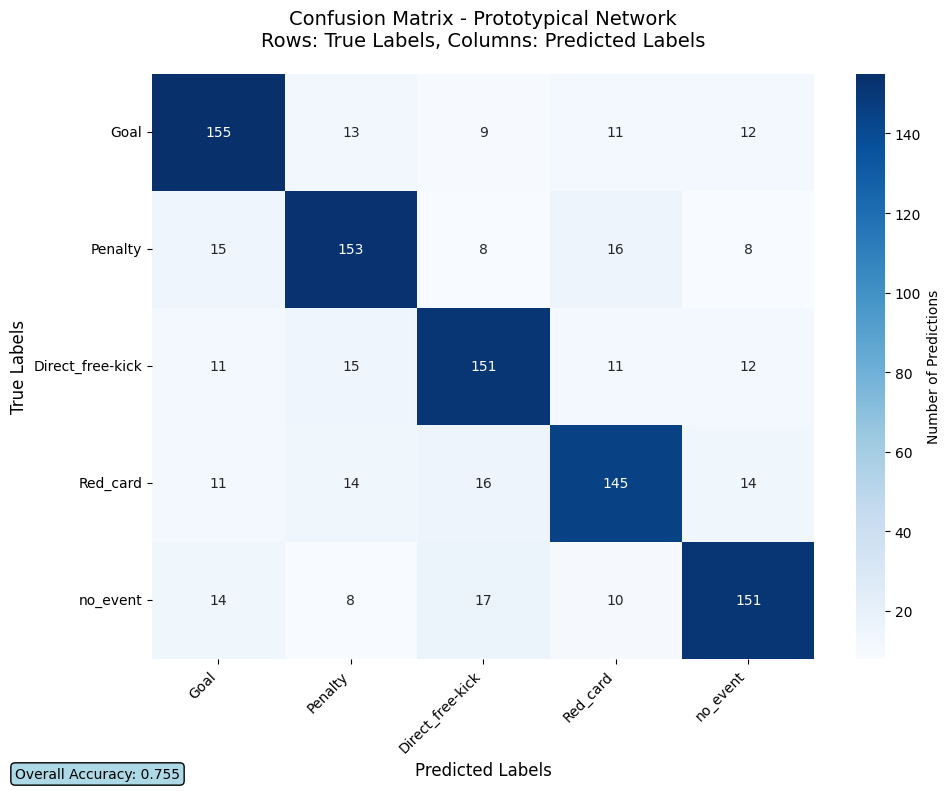

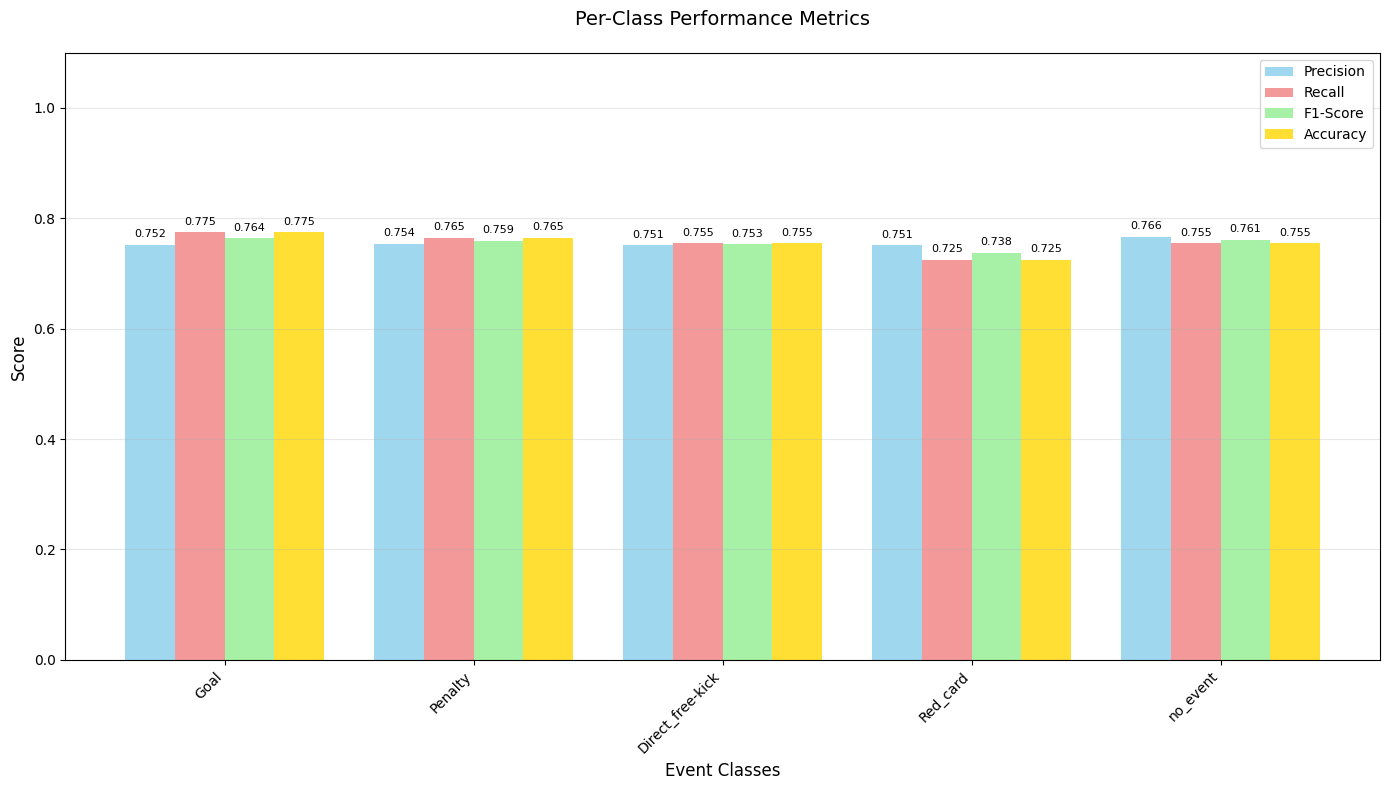

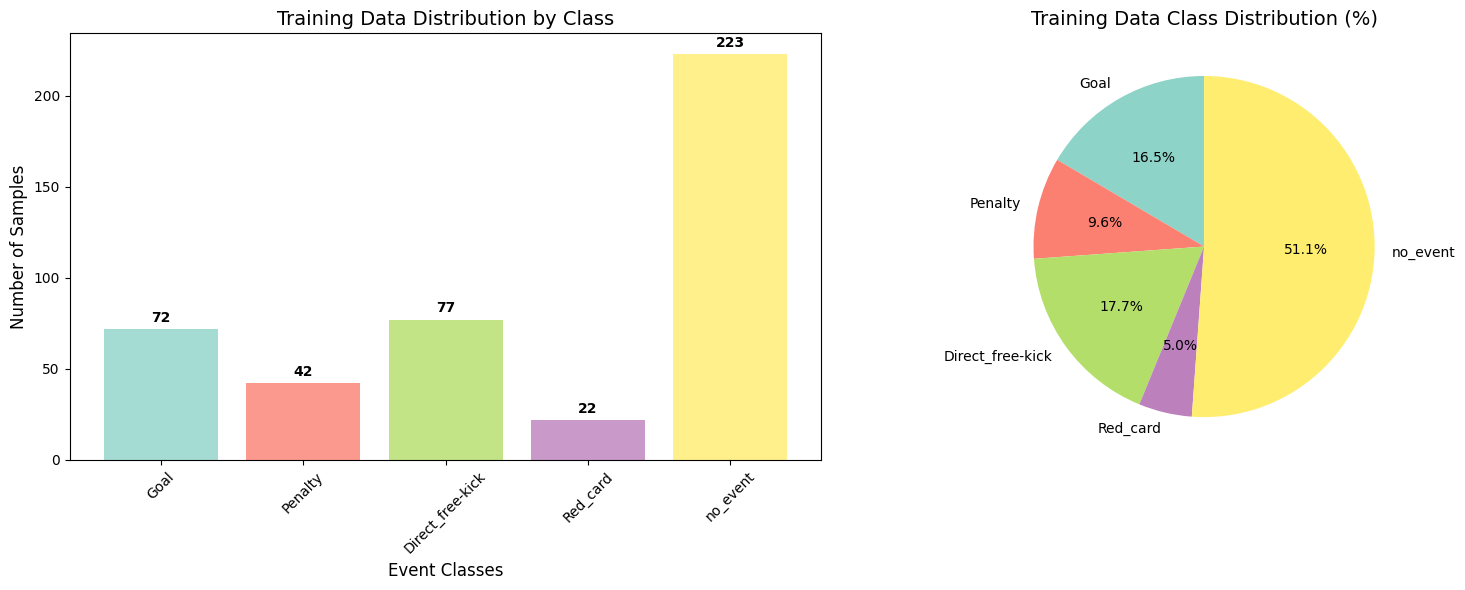


Confusion Matrix:
Rows: True labels, Columns: Predicted labels
Classes: ['Goal', 'Penalty', 'Direct_free-kick', 'Red_card', 'no_event']
[[155  13   9  11  12]
 [ 15 153   8  16   8]
 [ 11  15 151  11  12]
 [ 11  14  16 145  14]
 [ 14   8  17  10 151]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       200
           1       0.75      0.77      0.76       200
           2       0.75      0.76      0.75       200
           3       0.75      0.72      0.74       200
           4       0.77      0.76      0.76       200

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.75      1000
weighted avg       0.76      0.76      0.75      1000


MODIFIED MULTICLASS FEW-SHOT LEARNING COMPLETE!
Saved model to: Trained models/experiment\prototypical_network.pth
Saved config to: Trained models/experiment\model_config.json

Model saved successfully!
Model path: Trained m

In [ ]:
from typing import List, Dict, Tuple
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

class EpisodicDataLoader:
    def __init__(self, embeddings_dict: Dict[str, List[np.ndarray]], n_way: int, k_shot: int, n_query: int):
        """
        Initialize episodic data loader.
        
        Args:
            embeddings_dict: Dictionary of event classes and their embeddings.
            n_way: Number of classes per episode.
            k_shot: Number of support samples per class.
            n_query: Number of query samples per class.
        """
        self.embeddings_dict = embeddings_dict
        self.class_names = list(embeddings_dict.keys())
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_query = n_query

    def sample_episode(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Sample one episode with support and query sets.
        
        Returns:
            support_x: Support embeddings (N_support, embedding_dim).
            support_y: Support labels (N_support,).
            query_x: Query embeddings (N_query, embedding_dim).
            query_y: Query labels (N_query,).
        """
        # Randomly sample n_way classes
        episode_classes = np.random.choice(self.class_names, size=self.n_way, replace=False)

        support_x, support_y, query_x, query_y = [], [], [], []

        for class_idx, class_name in enumerate(episode_classes):
            class_embeddings = self.embeddings_dict[class_name]
            total_needed = self.k_shot + self.n_query

            # Sample embeddings for support and query
            if len(class_embeddings) < total_needed:
                indices = np.random.choice(len(class_embeddings), size=total_needed, replace=True)
            else:
                indices = np.random.choice(len(class_embeddings), size=total_needed, replace=False)

            for i, idx in enumerate(indices):
                if i < self.k_shot:
                    support_x.append(class_embeddings[idx])
                    support_y.append(class_idx)
                else:
                    query_x.append(class_embeddings[idx])
                    query_y.append(class_idx)

        # Convert to tensors
        support_x = torch.FloatTensor(np.stack(support_x))
        support_y = torch.LongTensor(support_y)
        query_x = torch.FloatTensor(np.stack(query_x))
        query_y = torch.LongTensor(query_y)

        return support_x, support_y, query_x, query_y
    
class PrototypicalNetwork(nn.Module):
    def __init__(self, embedding_dim: int = 3138, hidden_dim: int = 512, dropout_rate: float = 0.4):
        """
        Initialize Prototypical Network.
        
        Args:
            embedding_dim: Dimension of the input embeddings.
        """
        super().__init__()
        self.embedding_dim = embedding_dim
        # a simple trainable MLP
        self.feature_extractor = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_dim, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        # Learnable temperature parameter for better calibration
        self.temperature = nn.Parameter(torch.tensor(1.0))

    def compute_prototypes(self, support_x: torch.Tensor, support_y: torch.Tensor, n_way: int) -> torch.Tensor:
        """
        Compute class prototypes by averaging support embeddings.
        
        Args:
            support_x: Support embeddings (N_support, embedding_dim).
            support_y: Support labels (N_support,).
            n_way: Number of classes.
        
        Returns:
            prototypes: Class prototypes (n_way, embedding_dim).
        """
        prototypes = torch.zeros(n_way, self.embedding_dim).to(support_x.device)
        for class_idx in range(n_way):
            class_mask = (support_y == class_idx)
            class_embeddings = support_x[class_mask]
            prototypes[class_idx] = class_embeddings.mean(dim=0)
        return prototypes

    def forward(self, support_x: torch.Tensor, support_y: torch.Tensor, query_x: torch.Tensor, n_way: int) -> torch.Tensor:
        """
        Forward pass for Prototypical Network.
        
        Args:
            support_x: Support embeddings (N_support, embedding_dim).
            support_y: Support labels (N_support,).
            query_x: Query embeddings (N_query, embedding_dim).
            n_way: Number of classes.
        
        Returns:
            log_probs: Log probabilities for query samples (N_query, n_way).
        """
        # project both support and query through your feature extractor
        support_x = self.feature_extractor(support_x)
        query_x   = self.feature_extractor(query_x)
        
        # Compute prototypes
        prototypes = self.compute_prototypes(support_x, support_y, n_way)

        # Compute distances between query samples and prototypes
        distances = torch.cdist(query_x, prototypes, p=2)  # Euclidean distance

        # Apply temperature scaling to logits
        logits = -distances / self.temperature

        # Convert distances to log probabilities
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs
    
def train_prototypical_network(
    embeddings_dict: Dict[str, List[np.ndarray]],
    n_way: int = 5,
    k_shot: int = 5,
    n_query: int = 15,
    num_episodes: int = 1500,
    learning_rate: float = 1e-3
):
    """
    Train the Prototypical Network using episodic training.
    """
    model = PrototypicalNetwork(embedding_dim=3138)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    data_loader = EpisodicDataLoader(embeddings_dict, n_way, k_shot, n_query)

    model.train()
    for episode in range(num_episodes):
        support_x, support_y, query_x, query_y = data_loader.sample_episode()

        # Forward pass
        log_probs = model(support_x, support_y, query_x, n_way)

        # Compute loss
        loss = criterion(log_probs, query_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if episode % 100 == 0:
            with torch.no_grad():
                predictions = torch.argmax(log_probs, dim=1)
                accuracy = (predictions == query_y).float().mean().item()
                print(f"Episode {episode}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}")

    return model

def evaluate_prototypical_network(
    model: PrototypicalNetwork,
    test_embeddings_dict: Dict[str, List[np.ndarray]],
    n_way: int = 5,
    k_shot: int = 5,
    n_query: int = 10,
    num_episodes: int = 100
):
    """
    Evaluate the Prototypical Network on test episodes and compute full metrics.
    """
    model.eval()
    data_loader = EpisodicDataLoader(test_embeddings_dict, n_way, k_shot, n_query)

    accuracies, y_true, y_pred = [], [], []
    with torch.no_grad():
        for _ in range(num_episodes):
            support_x, support_y, query_x, query_y = data_loader.sample_episode()
            log_probs = model(support_x, support_y, query_x, n_way)
            preds = torch.argmax(log_probs, dim=1)
            accuracies.append((preds == query_y).float().mean().item())

            y_true.extend(query_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    overall_accuracy = np.mean(accuracies)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(n_way)))
    class_report = classification_report(
        y_true, y_pred, labels=list(range(n_way)), zero_division=0
    )
    precision = precision_score(
        y_true, y_pred, labels=list(range(n_way)), average="weighted", zero_division=0
    )
    recall = recall_score(
        y_true, y_pred, labels=list(range(n_way)), average="weighted", zero_division=0
    )
    f1 = f1_score(
        y_true, y_pred, labels=list(range(n_way)), average="weighted", zero_division=0
    )

    # per-class accuracy
    class_accuracies = {}
    for idx in range(n_way):
        mask = np.array(y_true) == idx
        correct = np.sum((np.array(y_true) == np.array(y_pred)) & mask)
        total = np.sum(mask)
        class_accuracies[idx] = correct / total if total > 0 else 0.0

    return {
        "overall_accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
        "classification_report": class_report,
        "class_accuracies": class_accuracies,
        "y_true": y_true,
        "y_pred": y_pred,
    }

        
def load_embeddings_for_meta_learning(base_path, event_classes, split):
    """
    Load embeddings into a dictionary for meta-learning.
    Args:
        base_path (str): Path to the embeddings folder.
        event_classes (list): List of event class names.
        split (str): "Train" or "Test".
    Returns:
        dict: Dictionary with class names as keys and list of embeddings as values.
    """
    embeddings_dict = {}
    for event in event_classes:
        folder = os.path.join(base_path, event, split)
        if not os.path.exists(folder):
            print(f"Warning: Folder not found for {event}/{split}")
            continue
        embeddings_dict[event] = [np.load(os.path.join(folder, f)) for f in os.listdir(folder) if f.endswith('.npy')]
    return embeddings_dict

def generate_detailed_evaluation_report(results, event_classes, embeddings_dict):
    """
    Print a detailed evaluation report.
    """
    print("\nStep 3: Additional Analysis...")
    print(f"Total evaluation samples: {len(results['y_true'])}")
    print(f"Number of classes: {len(event_classes)}")

    cm = results["confusion_matrix"]
    print("\nMost confused class pairs:")
    for i, t in enumerate(event_classes):
        for j, p in enumerate(event_classes):
            if i != j and cm[i, j] > 0:
                print(f"  {t} → {p}: {cm[i, j]} times")

    print("\n" + "=" * 70)
    print("FINAL RESULTS")
    print("=" * 70)
    print(f"Overall Accuracy: {results['overall_accuracy']:.4f}")
    print(f"Weighted Precision: {results['precision']:.4f}")
    print(f"Weighted Recall: {results['recall']:.4f}")
    print(f"Weighted F₁ Score: {results['f1_score']:.4f}")

    print("\nPer-class Accuracy:")
    for idx, acc in results["class_accuracies"].items():
        print(f"  {event_classes[idx]}: {acc:.4f}")
    
    plot_confusion_matrix(results, event_classes)

    plot_per_class_metrics(results, event_classes)

    plot_class_distribution(embeddings_dict, event_classes)

    print("\nConfusion Matrix:")
    print("Rows: True labels, Columns: Predicted labels")
    print(f"Classes: {event_classes}")
    print(cm)

    print("\nDetailed Classification Report:")
    print(results["classification_report"])

    print("\n" + "=" * 70)
    print("MODIFIED MULTICLASS FEW-SHOT LEARNING COMPLETE!")
    print("=" * 70)

def save_few_shot_model(model, embeddings_base_path, event_classes, save_dir="Trained models"):
    """
    Save the trained few-shot model and related components
    
    Args:
        model: Trained PrototypicalNetwork
        embeddings_base_path: Path to embeddings used for training
        event_classes: List of event class names
        save_dir: Directory to save the model
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model state dict
    model_path = os.path.join(save_dir, "prototypical_network_fused_final2_class.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Saved model to: {model_path}")
    
    # Save model configuration
    config = {
        'embedding_dim': model.embedding_dim,
        'hidden_dim': 512,  # From your model definition
        'dropout_rate': 0.3,  # From your model definition
        'event_classes': event_classes,
        'embeddings_base_path': embeddings_base_path
    }
    
    config_path = os.path.join(save_dir, "model_config_fused_final2_class.json")
    import json
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Saved config to: {config_path}")
    
    return model_path, config_path
# Step 3: Generate ResNet-50 Embeddings
def main():

    # Step 4: Few-Shot Learning
    embeddings_base_path = "F:\AIM Lab\Experiment\sliding-window\Fused_final2_concat"
    event_classes = ["Goal", "Penalty", "Direct_free-kick", "Red_card", "Substitution", "no_event"]
    # use all classes per episode
    n_way, k_shot, n_query = len(event_classes), 5, 15
    # 4.1: Train Prototypical Network
    print("Training Prototypical Network...")
    embeddings_dict = load_embeddings_for_meta_learning(embeddings_base_path, event_classes, split="Train")  # Implement this function to load embeddings into a dictionary
    model = train_prototypical_network(embeddings_dict, n_way=n_way, k_shot=k_shot, n_query=n_query, num_episodes=1500)

    # 4.2: Evaluate Prototypical Network
    print("Evaluating Prototypical Network...")
    test_embeddings_dict = load_embeddings_for_meta_learning(
        embeddings_base_path, event_classes, split="Test"
    )
    results = evaluate_prototypical_network(
        model, test_embeddings_dict, n_way=n_way, k_shot=k_shot, n_query=2, num_episodes=100
    )

    generate_detailed_evaluation_report(results, event_classes, embeddings_dict)

    # NEW: Save the trained model
    model_path, config_path = save_few_shot_model(
        model, embeddings_base_path, event_classes
    )
    print(f"\nModel saved successfully!")
    print(f"Model path: {model_path}")
    print(f"Config path: {config_path}")

    
if __name__ == "__main__":
    main()

# END

### generating resnet on clips(rbg)

In [ ]:
# Load ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove the final classifier to get 2048-d features
model.eval()  # Set the model to evaluation mode

# Preprocessing pipeline for frames
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                    # H×W×C → C×H×W, [0,1]
    torchvision.transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
    torchvision.transforms.Resize((224, 224)),
])

def embed_clip(frames: List[np.ndarray]):
    """
    Generate ResNet-50 embeddings for a list of frames.
    
    Args:
        frames (List[np.ndarray]): List of frames (H×W×C, BGR format).
    
    Returns:
        np.ndarray: Mean-pooled embedding (2048,) - single embedding per clip.
    """
    feats = []
    for frame in frames:
        # Convert BGR (OpenCV) to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x = preprocess(frame_rgb).unsqueeze(0)  # 1×3×224×224
        with torch.no_grad():
            f = model(x)  # 1×2048
        feats.append(f.squeeze(0).cpu().numpy())
    
    # Return mean-pooled embedding (single embedding per clip)
    return np.mean(feats, axis=0)  # (2048,)

def sample_frames_from_video(video_path, num_samples=16):
    """
    Uniformly sample num_samples frames from the video at video_path.
    Returns a list of BGR frames (as numpy arrays).
    """
    print(f"Opening video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")
    if total_frames == 0:
        print(f"Error: No frames found in video {video_path}")
        return []
    
    dynamic_num_samples = num_samples
    if total_frames > 250:
        # Add 6 samples for every 100 frames after 200
        additional_samples = ((total_frames - 200) // 100) * 6
        dynamic_num_samples = num_samples + additional_samples
        
        print(f"Video has {total_frames} frames (>250), using {dynamic_num_samples} samples "
              f"(base {num_samples} + {additional_samples} additional)")
    else:
        print(f"Video has {total_frames} frames (≤250), using {dynamic_num_samples} samples")
    
    # Sample frames
    if total_frames < dynamic_num_samples:
        # If fewer frames than samples, just read them all
        indices = list(range(total_frames))
        print(f"Warning: Only {total_frames} frames available, using all of them")
    else:
        # Uniformly spaced frame indices
        indices = np.linspace(0, total_frames - 1, num=dynamic_num_samples, dtype=int)

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Failed to read frame {idx} from {video_path}")
            continue
        frames.append(frame)
    cap.release()

    if not frames:
        print(f"Error: No frames sampled from video {video_path}")
    else:
        print(f"Successfully sampled {len(frames)} frames from {video_path}")
    
    return frames

def process_all_events(input_base_path, output_base_path, event_classes, num_samples=16):
    """
    Process all video clips in train/test folders for each event class.
    Generate ResNet-50 embeddings and save them maintaining the same directory structure.
    
    Args:
        input_base_path (str): Base path containing event folders
        output_base_path (str): Base path to save embeddings
        event_classes (list): List of event class names
        num_samples (int): Number of frames to sample per video
    """
    print(f"Processing videos from: {input_base_path}")
    print(f"Saving embeddings to: {output_base_path}")
    
    total_processed = 0
    
    for event in event_classes:
        event_input_folder = os.path.join(input_base_path, event)
        event_output_folder = os.path.join(output_base_path, event)
        
        if not os.path.exists(event_input_folder):
            print(f"Warning: Event folder not found: {event_input_folder}")
            continue
            
        print(f"\nProcessing event: {event}")
        
        # Process both train and test folders
        for split in ['train', 'test']:
            split_input_folder = os.path.join(event_input_folder, split)
            split_output_folder = os.path.join(event_output_folder, split)
            
            if not os.path.exists(split_input_folder):
                print(f"  Warning: Split folder not found: {split_input_folder}")
                continue
            
            # Create output directory
            os.makedirs(split_output_folder, exist_ok=True)
            
            print(f"  Processing {event}/{split}...")
            
            # Get all video files
            video_files = [f for f in os.listdir(split_input_folder) if f.lower().endswith('.mp4')]
            print(f"    Found {len(video_files)} videos")
            
            for fname in video_files:
                video_path = os.path.join(split_input_folder, fname)
                print(f"    Processing video: {fname}")
                
                # Sample frames from video
                frames = sample_frames_from_video(video_path, num_samples=num_samples)
                
                if frames:
                    # Generate mean-pooled embedding (single embedding per clip)
                    embedding = embed_clip(frames)
                    
                    # Save the embedding as a .npy file with same name
                    output_path = os.path.join(split_output_folder, f"{os.path.splitext(fname)[0]}.npy")
                    np.save(output_path, embedding)
                    print(f"    Saved embedding to {output_path} (shape: {embedding.shape})")
                    total_processed += 1
                else:
                    print(f"    Error: No frames sampled from {fname}")
    
    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE!")
    print(f"Total videos processed: {total_processed}")
    print(f"Embeddings saved to: {output_base_path}")
    print(f"{'='*60}")

# Example usage
if __name__ == "__main__":
    # Define paths
    input_base_path = "F:/AIM Lab/Experiment/sliding-window/Clips"
    output_base_path = "F:/AIM Lab/Experiment/sliding-window/Resnet-50 embeddings rgb"
    
    # Define event classes
    event_classes = [
        "Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty", 
        "Indirect_free-kick", "Corner", "Substitution", "Shots_on_target", "no_event"
    ]
    
    # Process all events with train/test structure
    process_all_events(
        input_base_path=input_base_path,
        output_base_path=output_base_path,
        event_classes=event_classes,
        num_samples=16
    )

### Fusion of modalities

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

def fuse_embeddings_with_attention(resnet_emb, yamnet_emb, audio_features, video_features, fusion_method):
    """
    Fuse ResNet-50 (2048-d) and YAMNet (1024-d) embeddings using different methods.
    
    Args:
        resnet_emb: ResNet-50 embedding (2048,)
        yamnet_emb: YAMNet embedding (1024,)
        fusion_method: 'concat', 'weighted_sum', 'attention', or 'learned_projection'
    
    Returns:
        fused_embedding: Combined embedding
    """
    
    if fusion_method == 'concat':
        # Simple concatenation (3072-d)
        return np.concatenate([resnet_emb,video_features, yamnet_emb, audio_features])
    
    elif fusion_method == 'weighted_sum':
        # Project to same dimension and weighted sum
        # Reduce ResNet to 1024-d through PCA-like projection
        resnet_projected = resnet_emb[:1024]  # Simple truncation
        # Weighted combination
        alpha = 0.7  # Weight for video features
        beta = 0.3   # Weight for audio features
        return alpha * resnet_projected + beta * yamnet_emb
    
    elif fusion_method == 'attention':
        # Attention-based fusion
        # Project both to same dimension (1024)
        resnet_projected = resnet_emb[:1024]
        
        # Compute attention weights
        combined = np.stack([resnet_projected, yamnet_emb])
        # Simple attention: softmax over modalities
        attention_weights = F.softmax(torch.tensor([np.mean(resnet_projected), np.mean(yamnet_emb)]), dim=0).numpy()
        
        # Weighted combination
        fused = attention_weights[0] * resnet_projected + attention_weights[1] * yamnet_emb
        return fused
    
    elif fusion_method == 'learned_projection':
        # Project both to common 512-d space
        # Simple linear projection (you could use learned weights here)
        resnet_proj = resnet_emb[::4]  # Downsample ResNet 2048->512
        yamnet_proj = yamnet_emb[::2]  # Downsample YAMNet 1024->512
        
        # Element-wise combination
        return (resnet_proj + yamnet_proj) / 2
    
    else:
        raise ValueError(f"Unknown fusion method: {fusion_method}")

def create_fused_embeddings(resnet_base_path, yamnet_base_path, audio_features_path, video_features_path, output_base_path, 
                          event_classes, fusion_method='attention'):
    """
    Create fused embeddings for all events and splits.
    
    Args:
        resnet_base_path: Path to ResNet-50 embeddings
        yamnet_base_path: Path to YAMNet embeddings  
        output_base_path: Path to save fused embeddings
        event_classes: List of event class names
        fusion_method: Method to fuse embeddings
    """
    
    os.makedirs(output_base_path, exist_ok=True)
    
    print(f"Creating fused embeddings using method: {fusion_method}")
    print(f"ResNet path: {resnet_base_path}")
    print(f"YAMNet path: {yamnet_base_path}")
    print(f"Audio features path: {audio_features_path}")
    print(f"Video features path: {video_features_path}")
    print(f"Output path: {output_base_path}")
    
    total_fused = 0
    
    for event in event_classes:
        for split in ["Train", "Test"]:
            resnet_folder = os.path.join(resnet_base_path, event, split)
            yamnet_folder = os.path.join(yamnet_base_path, event, split)
            audio_features_folder = os.path.join(audio_features_path, event, split)
            video_features_folder = os.path.join(video_features_path, event, split)
            output_folder = os.path.join(output_base_path, event, split)
            
            # Create output directory
            os.makedirs(output_folder, exist_ok=True)
            
            if not os.path.exists(resnet_folder) or not os.path.exists(yamnet_folder):
                print(f"Warning: Missing folder for {event}/{split}")
                continue
            
            # Get common files
            resnet_files = {f.replace('.npy', '') for f in os.listdir(resnet_folder) if f.endswith('.npy')}
            yamnet_files = {f.replace('.npy', '') for f in os.listdir(yamnet_folder) if f.endswith('.npy')}
            audio_files = {f.replace('.npy', '') for f in os.listdir(audio_features_folder) if f.endswith('.npy')}
            video_files = {f.replace('.npy', '') for f in os.listdir(video_features_folder) if f.endswith('.npy')}
            common_files = resnet_files.intersection(yamnet_files).intersection(audio_files).intersection(video_files)
            
            print(f"\n{event}/{split}: {len(common_files)} common files")
            
            for file_base in common_files:
                try:
                    # Load embeddings
                    resnet_emb = np.load(os.path.join(resnet_folder, f"{file_base}.npy"))
                    yamnet_emb = np.load(os.path.join(yamnet_folder, f"{file_base}.npy"))
                    audio_emb = np.load(os.path.join(audio_features_folder, f"{file_base}.npy"))
                    video_emb = np.load(os.path.join(video_features_folder, f"{file_base}.npy"))
                    
                    # Fuse embeddings
                    fused_emb = fuse_embeddings_with_attention(resnet_emb, yamnet_emb, audio_emb, video_emb, fusion_method)
                    
                    # Save fused embedding
                    output_path = os.path.join(output_folder, f"{file_base}.npy")
                    np.save(output_path, fused_emb)
                    
                    total_fused += 1
                    
                except Exception as e:
                    print(f"Error processing {file_base} for {event}/{split}: {e}")
            
            print(f"  Saved {len(common_files)} fused embeddings")
    
    print(f"\nTotal fused embeddings created: {total_fused}")
    return total_fused

# Create fused embeddings
if __name__ == "__main__":
    resnet_base_path = "F:/AIM Lab/Experiment/sliding-window/Resnet-50 embeddings rgb"
    yamnet_base_path = "F:/AIM Lab/Experiment/sliding-window/Yamnet-embeddings"
    audio_features_path = "F:/AIM Lab/Experiment/sliding-window/audio_features"
    video_features_path = "F:/AIM Lab/Experiment/sliding-window/video_features"

    output_base_path = "F:/AIM Lab/Experiment/sliding-window/Fused_final2"
    
    event_classes = ["Goal", "Red_card", "Yellow_card", "Direct_free-kick", "Penalty","Indirect_free-kick", "Substitution", "Shots_on_target", "Corner",  "no_event"]
    
    # Try different fusion methods
    fusion_methods = ['concat']
    
    for method in fusion_methods:
        method_output_path = f"{output_base_path}_{method}"
        print(f"\n{'='*60}")
        print(f"CREATING FUSED EMBEDDINGS: {method.upper()}")
        print(f"{'='*60}")
        
        total = create_fused_embeddings(
            resnet_base_path=resnet_base_path,
            yamnet_base_path=yamnet_base_path,
            audio_features_path=audio_features_path,
            video_features_path=video_features_path,
            output_base_path=method_output_path,
            event_classes=event_classes,
            fusion_method=method
        )
        
        print(f"Created {total} fused embeddings using {method} method")

### Modifying the no_event folder by adding examples of other(not interesting) events

In [ ]:
# ...existing code...
import os
import shutil
import re
from collections import defaultdict

def reorganize_no_event_embeddings(
        base_path: str,
        source_events = ("Substitution","Shots_on_target","Corner"),
        required_replacements: int = 3,
        dry_run: bool = False,
        allow_fallback: bool = True
    ):
    """
    For each match in no_event/Train:
      1. Identify first N (required_replacements) no_event files (lowest leading numbers) -> delete.
      2. Find lowest-number .npy from each source event for SAME match (Train or Test).
      3. Copy them into no_event/Train using the ORIGINAL deleted filenames but append _<Event>.npy.

    Parameters:
        base_path: root embeddings directory (contains event subfolders incl. no_event)
        source_events: events to draw negatives from
        required_replacements: normally 3
        dry_run: if True, only report actions
        allow_fallback: if True and some events missing, will reuse other available events (distinct files) until count reached
    """

    def parse_file(fname: str):
        """
        Returns (leading_number:int, match_tail:str) for '123_matchstuff.npy'
        match_tail has NO extension.
        """
        if not fname.endswith('.npy'):
            return None
        stem = fname[:-4]
        m = re.match(r'^(\d+)_(.+)$', stem)
        if not m:
            return None
        return int(m.group(1)), m.group(2)

    def build_index(events):
        """
        Build: event_index[event][match_tail] = sorted list of (leading_number, full_filename, full_path, split)
        """
        index = {e: defaultdict(list) for e in events}
        for e in events:
            for split in ("Train","Test"):
                folder = os.path.join(base_path, e, split)
                if not os.path.isdir(folder):
                    continue
                for f in os.listdir(folder):
                    if not f.endswith('.npy'):
                        continue
                    parsed = parse_file(f)
                    if not parsed:
                        continue
                    num, tail = parsed
                    index[e][tail].append( (num, f, os.path.join(folder,f), split) )
            # sort lists
            for tail, lst in index[e].items():
                lst.sort(key=lambda x: x[0])
        return index

    no_event_train = os.path.join(base_path, "no_event", "Train")
    if not os.path.isdir(no_event_train):
        print(f"ERROR: {no_event_train} not found.")
        return

    # Gather no_event files and group by match tail
    match_groups = defaultdict(list)
    for f in os.listdir(no_event_train):
        if not f.endswith('.npy'):
            continue
        parsed = parse_file(f)
        if not parsed:
            print(f"Skipping (unparsable): {f}")
            continue
        num, tail = parsed
        match_groups[tail].append( (num, f) )

    # Sort each group's files
    for tail in match_groups:
        match_groups[tail].sort(key=lambda x: x[0])

    print(f"Indexed {len(match_groups)} matches in no_event/Train")

    # Build source index
    print("Indexing source event files...")
    source_index = build_index(source_events)
    for e in source_events:
        print(f"  {e}: {sum(len(v) for v in source_index[e].values())} files indexed")

    processed = 0
    skipped = 0

    for match_tail, file_list in sorted(match_groups.items(), key=lambda x: x[0]):
        if len(file_list) < required_replacements:
            print(f"\nMatch '{match_tail}': only {len(file_list)} no_event files (<{required_replacements}) -> skip")
            skipped += 1
            continue

        to_delete = file_list[:required_replacements]
        print(f"\nMatch: {match_tail}")
        print(f"  Candidate deletions: {[f for _, f in to_delete]}")

        # Collect replacements: one per source event if present
        replacements = []  # list of dicts: {event, src_file, src_path, split, target_filename}
        missing_events = []

        for idx, event in enumerate(source_events):
            candidates = source_index[event].get(match_tail, [])
            if not candidates:
                missing_events.append(event)
                print(f"  {event:<15}: NONE")
                continue
            first = candidates[0]
            num_ev, fname_ev, path_ev, split_ev = first
            # Map to deletion slot if exists
            if idx < len(to_delete):
                tgt_original = to_delete[idx][1]
            else:
                # Extra (if allow_fallback later)
                tgt_original = to_delete[-1][1]
            new_name = tgt_original.replace('.npy', f'_{event}.npy')
            print(f"  {event:<15}: using {fname_ev} (split={split_ev}) -> {new_name}")
            replacements.append({
                "event": event,
                "src_file": fname_ev,
                "src_path": path_ev,
                "split": split_ev,
                "target_name": new_name
            })

        # Fallback: if allow_fallback and insufficient unique events, try to fill from existing events with additional distinct files
        if allow_fallback and len(replacements) < required_replacements:
            need = required_replacements - len(replacements)
            print(f"  Need {need} fallback replacement(s).")
            # collect additional distinct files from already present events (skip the file already chosen)
            for event in source_events:
                if need == 0:
                    break
                cand_list = source_index[event].get(match_tail, [])
                if len(cand_list) <= 1:
                    continue
                # skip the first (already used); iterate others
                for extra in cand_list[1:]:
                    if need == 0:
                        break
                    num_ev, fname_ev, path_ev, split_ev = extra
                    # choose next deletion slot not yet mapped
                    if len(replacements) < required_replacements:
                        tgt_original = to_delete[len(replacements)][1]
                    else:
                        tgt_original = to_delete[-1][1]
                    new_name = tgt_original.replace('.npy', f'_{event}_extra{num_ev}.npy')
                    print(f"    Fallback from {event}: {fname_ev} -> {new_name}")
                    replacements.append({
                        "event": event,
                        "src_file": fname_ev,
                        "src_path": path_ev,
                        "split": split_ev,
                        "target_name": new_name
                    })
                    need -= 1
                    if need == 0:
                        break

        if len(replacements) < required_replacements:
            print(f"  SKIP: only {len(replacements)}/{required_replacements} replacements found.")
            skipped += 1
            continue

        # Execute
        if dry_run:
            print("  DRY RUN: would delete and copy shown files.")
            processed += 1
            continue

        # Delete originals
        for _, fname in to_delete:
            path_del = os.path.join(no_event_train, fname)
            if os.path.exists(path_del):
                os.remove(path_del)
                print(f"  Deleted: {fname}")
            else:
                print(f"  Warning: expected to delete missing file {fname}")

        # Copy replacements
        for rep in replacements[:required_replacements]:
            dest_path = os.path.join(no_event_train, rep["target_name"])
            shutil.copy2(rep["src_path"], dest_path)
            print(f"  Copied: {rep['src_file']} ({rep['event']}) -> {rep['target_name']}")

        processed += 1

    print("\nSummary")
    print(f"  Matches processed: {processed}")
    print(f"  Matches skipped:   {skipped}")
    print(f"  Dry run:           {dry_run}")

if __name__ == "__main__":
    embeddings_base_path = r"F:\AIM Lab\Experiment\sliding-window\Fused_final2_concat"
    reorganize_no_event_embeddings(
        embeddings_base_path,
        dry_run=False,          # set True first to verify
        allow_fallback=True     # set False if you want strict 1-per-event requirement
    )
    
    print("Reorganizing no_event embeddings...")
    reorganize_no_event_embeddings(embeddings_base_path)
    print("Reorganization complete!")

SyntaxError: f-string: unmatched '[' (2604432372.py, line 155)